In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#!pip install fanalysis

from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# noms des variables de notre dataset y compris la variable identifiant IRIS
colonnes =["IDENT","TypeHabi", "GeoFaz_Scl", "GeoFaz_cl","Anciennete","Doublon_ligne",
            "Revenus_iris","Sexe","Prenom_Phase_scl_H", "Prenom_Phase_scl_F","Prenom_Phase_cl_H",
           "Prenom_Phase_cl_F","Age_H","Age_F","Pays_sud","Prenom_effectif","codif_RdB","Flag_PA",
           "Annee_1er_don","Cumul_dons","Don_max","Don_moyen","Vingtiles_ISF","IFI+"]

In [4]:
# importation du fichier (changer le chemin d'accès)
''' Faites attention au type de fichier, au délimiteur des valeurs (ça doit être unique et non multiple),
au header et à la lecture des types d'objets (low_memory) '''
#/content/drive/MyDrive/Stage_methods_spad/data_excel_2.csv
data_orig = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/my_data_FDFIFI19.txt",delim_whitespace="\t" , header = None, names=colonnes, low_memory=False, )#, dtype='Int64')

In [5]:
''' copie superficielle (peu profonde) du dataset original pour ne pas modifier les valeurs
d'origine par erreur plus tard 
'''
data = data_orig.copy()
data.shape

(484522, 24)

In [6]:
# visualisation des premiers lignes
data.head()

,IDENT,TypeHabi,GeoFaz_Scl,GeoFaz_cl,Anciennete,Doublon_ligne,Revenus_iris,Sexe,Prenom_Phase_scl_H,Prenom_Phase_scl_F,Prenom_Phase_cl_H,Prenom_Phase_cl_F,Age_H,Age_F,Pays_sud,Prenom_effectif,codif_RdB,Flag_PA,Annee_1er_don,Cumul_dons,Don_max,Don_moyen,Vingtiles_ISF,IFI+
0,101001347,3,75,7,8,3,3,3,64,46,6,4,9,4,2,3,3,2,7,7,6,4,10,2.0
1,201001512,1,74,7,5,3,3,4,65,81,6,8,11,12,2,4,3,2,8,5,2,2,10,2.0
2,301002801,2,32,3,7,2,4,4,66,66,6,6,11,9,2,3,3,2,8,7,5,3,7,2.0
3,401003186,1,12,1,4,3,7,3,51,81,5,8,9,12,2,5,1,2,2,7,8,6,18,2.0
4,501003624,2,12,1,6,3,3,3,51,81,5,8,9,12,2,5,1,2,8,7,8,6,2,2.0


In [7]:
#nombre de modalités de chaque variables (dans un dataframe)
def nombre_mod(data2):
    #création d'un dataframe vide
    dff= pd.DataFrame(columns=["VARIABLE","NOMBRE_MOD", "NOMBRE_MOD_SANS_NA"])
    for i in range(data2.shape[1]): # sans compter les valeurs manquantes
        taille =len(data2.iloc[:,i].value_counts(dropna=False))
        taille_1 = len(data2.iloc[:,i].value_counts(dropna=True) )
        dff=dff.append({"VARIABLE": colonnes[i],"NOMBRE_MOD":taille, "NOMBRE_MOD_SANS_NA":taille_1 }, ignore_index=True)
    return dff

# sélection des corrélations les plus importantes
def variables_corr(tableau_corr, seuil):
    variables_corr_pos=[] ; variables_corr_pos_val=[]
    variables_corr_neg=[] ; variables_corr_neg_val=[]
    for i in range(tableau_corr.shape[0]):  
        for j in range(tableau_corr.shape[0]):
            if i<j: #i!=j:
                if (tableau_corr.iloc[i,j] > seuil):
                    variables_corr_pos.append(colonnes[j+1])
                    variables_corr_pos_val.append(round( tableau_corr.iloc[i,j], 2))
                if (tableau_corr.iloc[i,j] <-seuil):
                    variables_corr_neg.append(colonnes[j+1])
                    variables_corr_neg_val.append(round( tableau_corr.iloc[i,j], 2))

        if (len(variables_corr_pos) > 0) | (len(variables_corr_neg) >0) :
            print("variable : ", colonnes[i+1])
            if len(variables_corr_pos) > 0:    
                print("corr pos", variables_corr_pos)
                print("corr pos", variables_corr_pos_val)
            if len(variables_corr_neg) >0:  
                print("corr neg", variables_corr_neg)
                print("corr neg", variables_corr_neg_val)
            print("")
        variables_corr_pos = variables_corr_pos*0
        variables_corr_neg = variables_corr_pos*0

        variables_corr_pos_val = variables_corr_pos_val*0
        variables_corr_neg_val = variables_corr_pos_val*0


def evaluation(model, X_train, y_train, X_test, y_test, scoring):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("test set : ")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred)) 
    print("train set : ")
    print(confusion_matrix(y_train, model.predict(X_train))) # ajouter 
    print(classification_report(y_train, model.predict(X_train) ))

    N, train_score, val_score = learning_curve(model, X_train, y_train,shuffle=True, cv = 4, scoring = scoring, train_sizes = np.linspace(0.1, 1, 6) )

    plt.figure(figsize = (10,6))
    plt.plot(N, train_score.mean(axis=1), label ="train_score")
    plt.plot(N, val_score.mean(axis=1), label ="cross_validation_score")

    plt.legend()

# Comme il n'y a pas de valeurs manquantes (à la place il y a un nombre), le seul traitement qu'on fait c'est tranformer
# le type de variable (les variables continues deviennent qualitatives)
def data_processing(df):
    """ 
    for i in range(0,len(df.columns)):    
        df[df.columns[i]].fillna(100.0, inplace=True) #On remplace les données manquantes par 100
    for i in range(0,len(df.columns)):
        print(df[df.columns[i]].value_counts(dropna=False))    
    """
    
   #Transformation de toutes les variables en facteurs         
    for i in range(0,len(df.columns)):
        df[df.columns[i]] = df[df.columns[i]].astype('category')
    return df.to_numpy() #.as_matrix()



In [8]:
# élimination des individus n'ayant pas de valeurs pour la variable IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]


In [9]:
#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [10]:
data = data_sans_nan

In [11]:
data["IFI+"].value_counts()

2    462833
1      2620
Name: IFI+, dtype: int64

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve, GridSearchCV

In [ ]:
####################################################################################
#                            MODELE 1 : BOOSTING
####################################################################################

In [ ]:
# base de données avec des variables corrélées et sans encodage OneHot

train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )
# numéro correspondant à la dernière colonne
nb_var = data.shape[1] - 1

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

In [ ]:
model_AdaBoost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight = "balanced"), random_state =0 )
param = {'base_estimator__criterion': ['gini','entropy'], 'base_estimator__max_depth' : list(range(2,20, 2)), 'n_estimators' : [10,20,30,40,50] }

grid_AdaBoost = GridSearchCV(model_AdaBoost, param, cv = 4, scoring = "recall")
resultat_grid_AdaBoost = grid_AdaBoost.fit(train_X_s, train_Y_s)
resultat_grid_AdaBoost.best_params_
#model_AdaBoost.get_params



{'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 2,
 'n_estimators': 10}

test set : 
[[  410    88]
 [ 9891 82702]]
              precision    recall  f1-score   support

           1       0.04      0.82      0.08       498
           2       1.00      0.89      0.94     92593

    accuracy                           0.89     93091
   macro avg       0.52      0.86      0.51     93091
weighted avg       0.99      0.89      0.94     93091

train set : 
[[  1797    325]
 [ 39111 331129]]
              precision    recall  f1-score   support

           1       0.04      0.85      0.08      2122
           2       1.00      0.89      0.94    370240

    accuracy                           0.89    372362
   macro avg       0.52      0.87      0.51    372362
weighted avg       0.99      0.89      0.94    372362



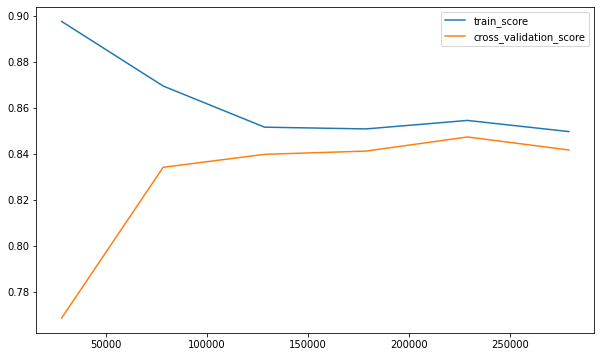

In [ ]:
final_model_AdaBoost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(class_weight="balanced", criterion="gini",max_depth=2),n_estimators = 10 , random_state=0 ) 
evaluation(final_model_AdaBoost, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [ ]:
#############################################################
#                   MODELE 2 : BOOSTING
#############################################################

In [ ]:

model_GradientBoostingClassifier = GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1,
                                                              subsample=1,max_features='sqrt', random_state=10)
param = { 'n_estimators':[100,250,500],
         'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001] }

grid_GradientBoostingClassifier = GridSearchCV(model_GradientBoostingClassifier, param_grid= param, cv = 4, scoring = "recall")
resultat_grid_GradientBoostingClassifier = grid_GradientBoostingClassifier.fit(train_X_s, train_Y_s)
resultat_grid_GradientBoostingClassifier.best_params_


{'learning_rate': 0.15, 'n_estimators': 500}

test set : 
[[    2   496]
 [   11 92582]]
              precision    recall  f1-score   support

           1       0.15      0.00      0.01       498
           2       0.99      1.00      1.00     92593

    accuracy                           0.99     93091
   macro avg       0.57      0.50      0.50     93091
weighted avg       0.99      0.99      0.99     93091

train set : 
[[    96   2026]
 [    16 370224]]
              precision    recall  f1-score   support

           1       0.86      0.05      0.09      2122
           2       0.99      1.00      1.00    370240

    accuracy                           0.99    372362
   macro avg       0.93      0.52      0.54    372362
weighted avg       0.99      0.99      0.99    372362



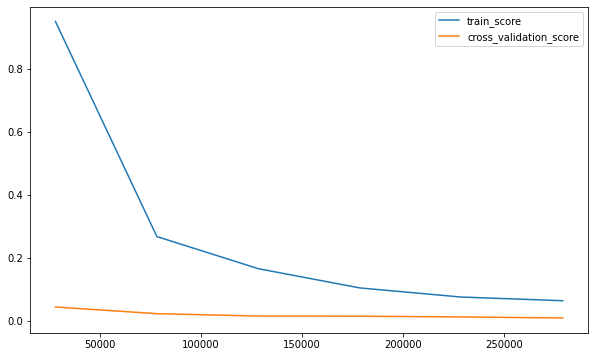

In [ ]:
final_model_GradientBoostingClassifier = GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1,
                                                              subsample=1,max_features='sqrt', random_state=10,
                                                              learning_rate= 0.15, n_estimators= 500)
evaluation(final_model_GradientBoostingClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [ ]:
#######################################################################################################################
#                                                ARBRES DE DECISION
#######################################################################################################################

In [ ]:
# base de données avec des variables corrélées et sans encodage OneHot

train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )
# numéro correspondant à la dernière colonne
nb_var = data.shape[1] - 1

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

In [ ]:

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, class_weight = "balanced" )
param = { 'max_depth' :list(range(2,30)), 'criterion': ["gini", "entropy"], 'max_features' : list(range(5,19)),
         'min_samples_split' : np.linspace(0.1, 1.0, 5) }

grid_DecisionTreeClassifier = GridSearchCV(model_DecisionTreeClassifier, param_grid= param, cv = 4, scoring = "recall")
resultat_grid_DecisionTreeClassifier = grid_DecisionTreeClassifier.fit(train_X_s, train_Y_s)
resultat_grid_DecisionTreeClassifier.best_params_


{'criterion': 'entropy',
 'max_depth': 2,
 'max_features': 5,
 'min_samples_split': 0.1}

test set : 
[[  471    27]
 [45168 47425]]
              precision    recall  f1-score   support

           1       0.01      0.95      0.02       498
           2       1.00      0.51      0.68     92593

    accuracy                           0.51     93091
   macro avg       0.50      0.73      0.35     93091
weighted avg       0.99      0.51      0.67     93091

train set : 
[[  2015    107]
 [180302 189938]]
              precision    recall  f1-score   support

           1       0.01      0.95      0.02      2122
           2       1.00      0.51      0.68    370240

    accuracy                           0.52    372362
   macro avg       0.51      0.73      0.35    372362
weighted avg       0.99      0.52      0.67    372362



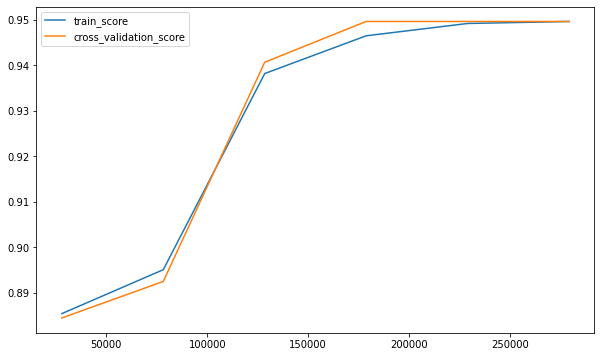

In [ ]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="entropy", class_weight = "balanced", max_depth = 2, max_features=5, min_samples_split=0.1 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [ ]:

# importance des variables
impVarFirst={"Variable":data.columns[1:-1],"Importance":final_model_DecisionTreeClassifier.feature_importances_}
pd.DataFrame(impVarFirst).sort_values(by="Importance",ascending=False)

,Variable,Importance
20,Don_moyen,0.732512
1,GeoFaz_Scl,0.218157
8,Prenom_Phase_scl_F,0.049330
0,TypeHabi,0.000000
12,Age_F,0.000000
19,Don_max,0.000000
18,Cumul_dons,0.000000
17,Annee_1er_don,0.000000
16,Flag_PA,0.000000
15,codif_RdB,0.000000


[Text(418.5, 453.0, 'GeoFaz_Scl <= 67.5\nentropy = 1.0\nsamples = 372362\nvalue = [186181.0, 186181.0]'),
 Text(209.25, 271.8, 'Don_moyen <= 4.5\nentropy = 0.952\nsamples = 237293\nvalue = [70190.763, 118924.22]'),
 Text(104.625, 90.59999999999997, 'entropy = 0.435\nsamples = 190045\nvalue = [9388.015, 95513.307]'),
 Text(313.875, 90.59999999999997, 'entropy = 0.853\nsamples = 47248\nvalue = [60802.749, 23410.913]'),
 Text(627.75, 271.8, 'Prenom_Phase_scl_F <= 78.5\nentropy = 0.948\nsamples = 135069\nvalue = [115990.237, 67256.78]'),
 Text(523.125, 90.59999999999997, 'entropy = 0.996\nsamples = 76439\nvalue = [44483.396, 38183.599]'),
 Text(732.375, 90.59999999999997, 'entropy = 0.867\nsamples = 58630\nvalue = [71506.84, 29073.181]')]

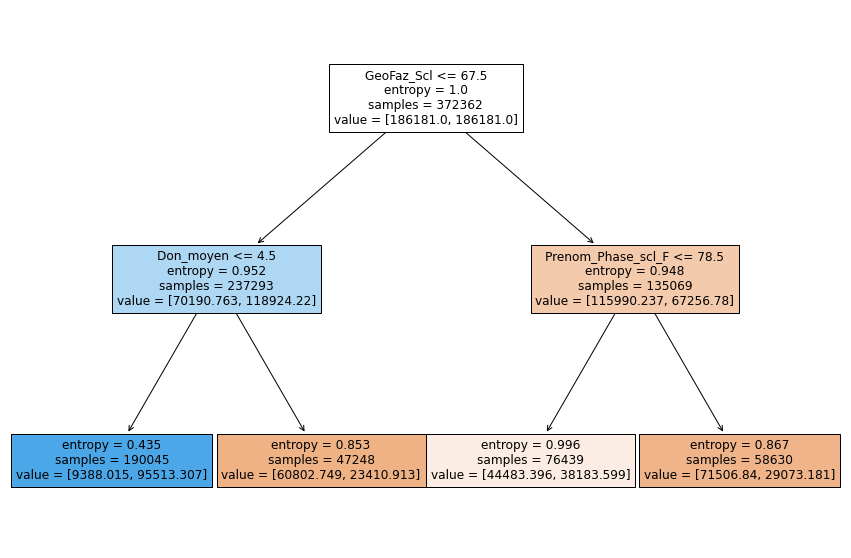

In [ ]:
# affichage graphique de l'arbre (il faut vérifier les noms des colonnes pour qu'on affiche correctement l'arbre)

plt.figure(figsize = (15, 10))
plot_tree(final_model_DecisionTreeClassifier,feature_names = list(data.columns[1:-1]),filled=True)



In [ ]:
##################################################################
# ELIMINATION DES VARIABLES QUI CONTRIBUENT LE PLUS AU MODELE
##################################################################

In [ ]:
# PARTIE 1 : on élimine la variable qui contribue le plus au modèle précédent
data=data.drop(["Don_moyen"],axis=1)


In [ ]:
# base de données avec des variables corrélées et sans encodage OneHot

train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )
nb_var = data.shape[1] - 1

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

In [ ]:

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, class_weight = "balanced" )
param = { 'max_depth' :list(range(2,30)), 'criterion': ["gini", "entropy"], 'max_features' : list(range(5,15)),
         'min_samples_split' : np.linspace(0.1, 1.0, 5) }

grid_DecisionTreeClassifier = GridSearchCV(model_DecisionTreeClassifier, param_grid= param, cv = 4, scoring = "recall")
resultat_grid_DecisionTreeClassifier = grid_DecisionTreeClassifier.fit(train_X_s, train_Y_s)
resultat_grid_DecisionTreeClassifier.best_params_


{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 9,
 'min_samples_split': 0.1}

test set : 
[[  417    81]
 [12540 80053]]
              precision    recall  f1-score   support

           1       0.03      0.84      0.06       498
           2       1.00      0.86      0.93     92593

    accuracy                           0.86     93091
   macro avg       0.52      0.85      0.49     93091
weighted avg       0.99      0.86      0.92     93091

train set : 
[[  1828    294]
 [ 50227 320013]]
              precision    recall  f1-score   support

           1       0.04      0.86      0.07      2122
           2       1.00      0.86      0.93    370240

    accuracy                           0.86    372362
   macro avg       0.52      0.86      0.50    372362
weighted avg       0.99      0.86      0.92    372362



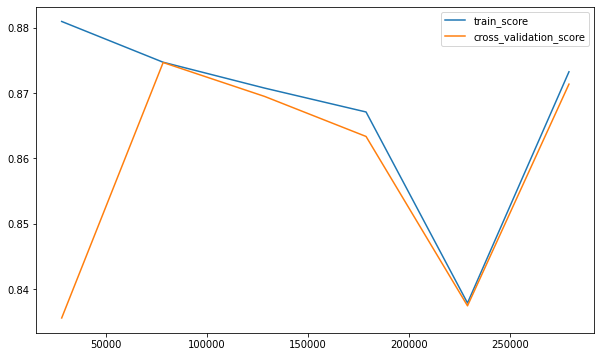

In [ ]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="gini", class_weight = "balanced", max_depth = 8, max_features=9, min_samples_split=0.1 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [ ]:

#importance des variables
impVarFirst={"Variable":data.columns[1:-1],"Importance":final_model_DecisionTreeClassifier.feature_importances_}
pd.DataFrame(impVarFirst).sort_values(by="Importance",ascending=False)

,Variable,Importance
18,Cumul_dons,0.669001
19,Don_max,0.298596
5,Revenus_iris,0.013495
20,Vingtiles_ISF,0.010643
1,GeoFaz_Scl,0.002385
4,Doublon_ligne,0.002374
2,GeoFaz_cl,0.001567
6,Sexe,0.000941
7,Prenom_Phase_scl_H,0.000686
12,Age_F,0.000313


[Text(642.9130434782609, 513.4, 'Cumul_dons <= 5.5\ngini = 0.5\nsamples = 372362\nvalue = [186181.0, 186181.0]'),
 Text(545.8695652173913, 453.0, 'Don_max <= 6.5\ngini = 0.36\nsamples = 329300\nvalue = [50976.042, 165301.513]'),
 Text(497.3478260869565, 392.6, 'Don_max <= 5.5\ngini = 0.249\nsamples = 308676\nvalue = [26409.275, 155071.213]'),
 Text(363.9130434782609, 332.2, 'Vingtiles_ISF <= 19.5\ngini = 0.173\nsamples = 251748\nvalue = [13336.245, 126519.001]'),
 Text(315.39130434782606, 271.8, 'Doublon_ligne <= 2.5\ngini = 0.152\nsamples = 245526\nvalue = [11142.784, 123402.742]'),
 Text(194.08695652173913, 211.39999999999998, 'GeoFaz_Scl <= 71.5\ngini = 0.214\nsamples = 90712\nvalue = [6317.169, 45579.748]'),
 Text(145.56521739130434, 151.0, 'Revenus_iris <= 7.5\ngini = 0.17\nsamples = 69176\nvalue = [3597.277, 34765.621]'),
 Text(97.04347826086956, 90.59999999999997, 'Sexe <= 2.5\ngini = 0.167\nsamples = 69147\nvalue = [3509.538, 34751.541]'),
 Text(48.52173913043478, 30.1999999999

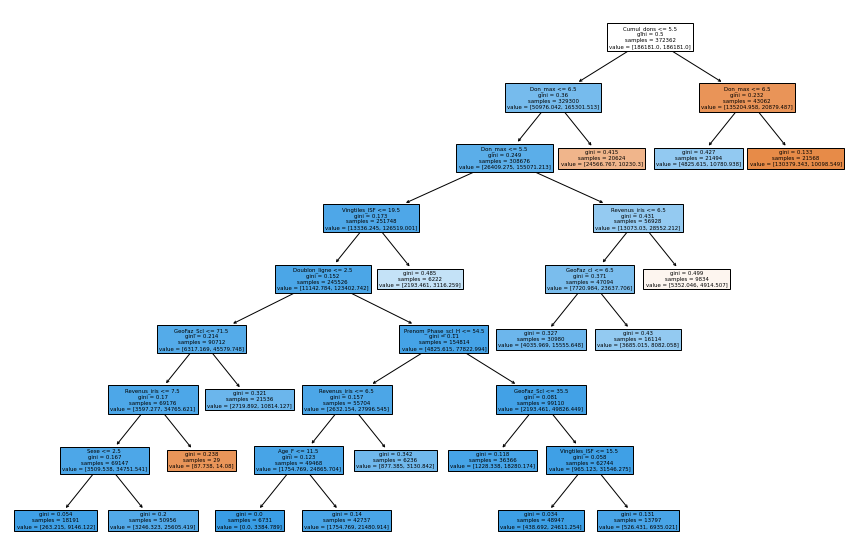

In [ ]:
# affichage graphique de l'arbre (il faut vérifier les noms des colonnes pour qu'on affiche correctement l'arbre)

plt.figure(figsize = (15, 10))
plot_tree(final_model_DecisionTreeClassifier,feature_names = list(data.columns[1:-1]),filled=True)



In [ ]:
##################################################################
##################################################################

In [ ]:
# PARTIE 2 (LA SUITE) : on élimine la variable qui contribue le plus au modèle précédent
data=data.drop(["Annee_1er_don", "Cumul_dons","Don_max"],axis=1)


In [ ]:
# base de données avec des variables corrélées et sans encodage OneHot

train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )
nb_var = data.shape[1] - 1

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

In [ ]:

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, class_weight = "balanced" )
param = { 'max_depth' :list(range(2,30)), 'criterion': ["gini", "entropy"], 'max_features' : list(range(5,15)),
         'min_samples_split' : np.linspace(0.1, 1.0, 5) }

grid_DecisionTreeClassifier = GridSearchCV(model_DecisionTreeClassifier, param_grid= param, cv = 4, scoring = "recall")
resultat_grid_DecisionTreeClassifier = grid_DecisionTreeClassifier.fit(train_X_s, train_Y_s)
resultat_grid_DecisionTreeClassifier.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 7,
 'min_samples_split': 0.1}

test set : 
[[  385   113]
 [43574 49019]]
              precision    recall  f1-score   support

           1       0.01      0.77      0.02       498
           2       1.00      0.53      0.69     92593

    accuracy                           0.53     93091
   macro avg       0.50      0.65      0.35     93091
weighted avg       0.99      0.53      0.69     93091

train set : 
[[  1609    513]
 [174487 195753]]
              precision    recall  f1-score   support

           1       0.01      0.76      0.02      2122
           2       1.00      0.53      0.69    370240

    accuracy                           0.53    372362
   macro avg       0.50      0.64      0.35    372362
weighted avg       0.99      0.53      0.69    372362



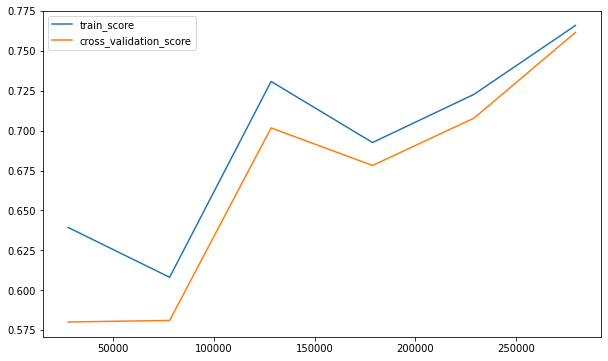

In [ ]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="gini", class_weight = "balanced", max_depth = 2, max_features=7, min_samples_split=0.1 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [ ]:

#importance des variables
impVarFirst={"Variable":data.columns[1:-1],"Importance":final_model_DecisionTreeClassifier.feature_importances_}
pd.DataFrame(impVarFirst).sort_values(by="Importance",ascending=False)

,Variable,Importance
1,GeoFaz_Scl,0.651813
17,Vingtiles_ISF,0.199837
7,Prenom_Phase_scl_H,0.148350
10,Prenom_Phase_cl_F,0.000000
16,Flag_PA,0.000000
15,codif_RdB,0.000000
14,Prenom_effectif,0.000000
13,Pays_sud,0.000000
12,Age_F,0.000000
11,Age_H,0.000000


[Text(418.5, 453.0, 'GeoFaz_Scl <= 67.5\ngini = 0.5\nsamples = 372362\nvalue = [186181.0, 186181.0]'),
 Text(209.25, 271.8, 'Vingtiles_ISF <= 15.5\ngini = 0.467\nsamples = 237293\nvalue = [70190.763, 118924.22]'),
 Text(104.625, 90.59999999999997, 'gini = 0.431\nsamples = 196266\nvalue = [45009.827, 98437.471]'),
 Text(313.875, 90.59999999999997, 'gini = 0.495\nsamples = 41027\nvalue = [25180.936, 20486.749]'),
 Text(627.75, 271.8, 'Prenom_Phase_scl_H <= 55.5\ngini = 0.465\nsamples = 135069\nvalue = [115990.237, 67256.78]'),
 Text(523.125, 90.59999999999997, 'gini = 0.406\nsamples = 55652\nvalue = [69752.071, 27585.704]'),
 Text(732.375, 90.59999999999997, 'gini = 0.497\nsamples = 79417\nvalue = [46238.165, 39671.076]')]

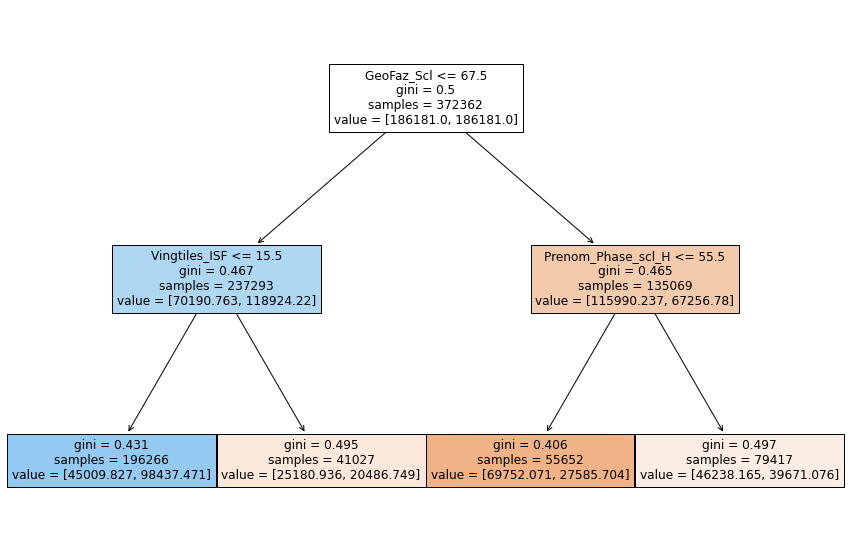

In [ ]:
# affichage graphique de l'arbre (il faut vérifier les noms des colonnes pour qu'on affiche correctement l'arbre)

plt.figure(figsize = (15, 10))
plot_tree(final_model_DecisionTreeClassifier,feature_names = list(data.columns[1:-1]),filled=True)



In [ ]:
##################################################################
##################################################################
##################################################################

In [ ]:
# PARTIE 3 : éliminer les variables corrélées
# tableau de corrélation 
tableau_corr =data_sans_nan.iloc[:,1:23].corr()
variables_corr(tableau_corr, 0.95)


variable :  GeoFaz_Scl
corr pos ['GeoFaz_cl']
corr pos [1.0]

variable :  Prenom_Phase_scl_H
corr pos ['Prenom_Phase_cl_H']
corr pos [0.99]

variable :  Prenom_Phase_scl_F
corr pos ['Prenom_Phase_cl_F']
corr pos [0.99]



In [ ]:
 # éliminer les variables corrélées
data =  data.drop(["GeoFaz_cl", "Prenom_Phase_cl_H", "Prenom_Phase_cl_F"], axis = 1)


In [ ]:
# base de données avec des variables corrélées et sans encodage OneHot

train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )
nb_var = data.shape[1] - 1

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

In [ ]:

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, class_weight = "balanced" )
param = { 'max_depth' :list(range(2,30)), 'criterion': ["gini", "entropy"], 'max_features' : list(range(4,10)),
         'min_samples_split' : np.linspace(0.1, 1.0, 5) }

grid_DecisionTreeClassifier = GridSearchCV(model_DecisionTreeClassifier, param_grid= param, cv = 4, scoring = "recall")
resultat_grid_DecisionTreeClassifier = grid_DecisionTreeClassifier.fit(train_X_s, train_Y_s)
resultat_grid_DecisionTreeClassifier.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 8,
 'min_samples_split': 0.325}

test set : 
[[  367   131]
 [39021 53572]]
              precision    recall  f1-score   support

           1       0.01      0.74      0.02       498
           2       1.00      0.58      0.73     92593

    accuracy                           0.58     93091
   macro avg       0.50      0.66      0.38     93091
weighted avg       0.99      0.58      0.73     93091

train set : 
[[  1518    604]
 [155796 214444]]
              precision    recall  f1-score   support

           1       0.01      0.72      0.02      2122
           2       1.00      0.58      0.73    370240

    accuracy                           0.58    372362
   macro avg       0.50      0.65      0.38    372362
weighted avg       0.99      0.58      0.73    372362



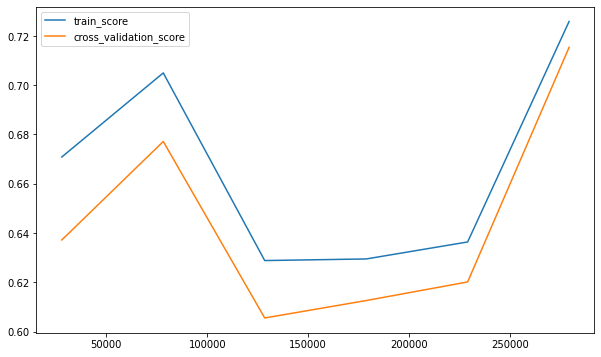

In [ ]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="entropy", class_weight = "balanced", max_depth = 3, max_features=8, min_samples_split=0.325 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [ ]:

#importance des variables
impVarFirst={"Variable":data.columns[1:-1],"Importance":final_model_DecisionTreeClassifier.feature_importances_}
pd.DataFrame(impVarFirst).sort_values(by="Importance",ascending=False)

,Variable,Importance
4,Revenus_iris,0.765341
1,GeoFaz_Scl,0.151920
6,Prenom_Phase_scl_H,0.082739
0,TypeHabi,0.000000
2,Anciennete,0.000000
3,Doublon_ligne,0.000000
5,Sexe,0.000000
7,Prenom_Phase_scl_F,0.000000
8,Age_H,0.000000
9,Age_F,0.000000


[Text(558.0, 475.65000000000003, 'Revenus_iris <= 6.5\nentropy = 1.0\nsamples = 372362\nvalue = [186181.0, 186181.0]'),
 Text(418.5, 339.75, 'GeoFaz_Scl <= 67.5\nentropy = 0.97\nsamples = 318574\nvalue = [105373.884, 159595.999]'),
 Text(279.0, 203.85000000000002, 'Prenom_Phase_scl_H <= 65.5\nentropy = 0.914\nsamples = 215048\nvalue = [52994.026, 107836.534]'),
 Text(139.5, 67.94999999999999, 'entropy = 0.962\nsamples = 127219\nvalue = [40008.735, 63744.766]'),
 Text(418.5, 67.94999999999999, 'entropy = 0.774\nsamples = 87829\nvalue = [12985.291, 44091.768]'),
 Text(558.0, 203.85000000000002, 'entropy = 1.0\nsamples = 103526\nvalue = [52379.857, 51759.465]'),
 Text(697.5, 339.75, 'entropy = 0.807\nsamples = 53788\nvalue = [80807.116, 26585.001]')]

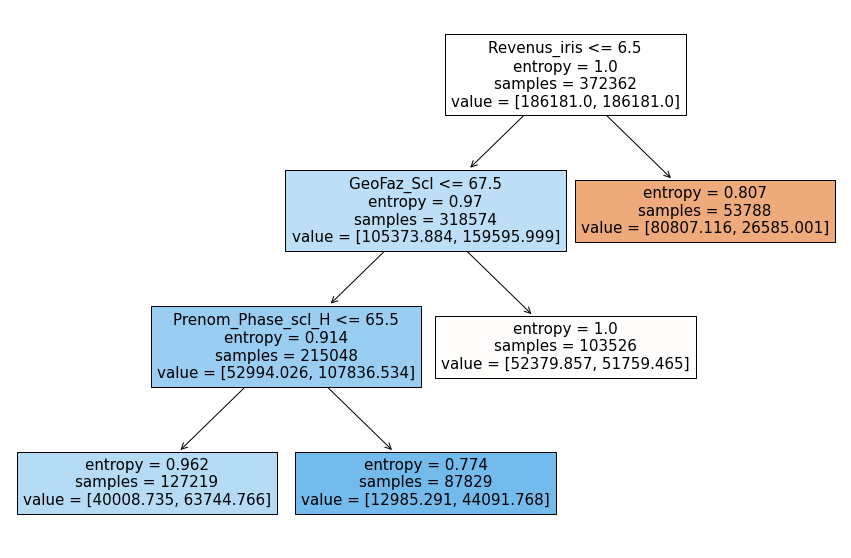

In [ ]:
# affichage graphique de l'arbre (il faut vérifier les noms des colonnes pour qu'on affiche correctement l'arbre)

plt.figure(figsize = (15, 10))
plot_tree(final_model_DecisionTreeClassifier,feature_names = list(data.columns[1:-1]),filled=True)



In [ ]:
#################################################################################################################
#                                                 QUARANTILES               
#################################################################################################################

In [34]:
def quarantiles(model, data_orig, affichage, save, path):
    # position de la dernière variable explicative dans le dataset
    nb_var = data_orig.shape[1]-1

    # predict sur tous les individus (avec et sans classe IFI+)
    tous_probas = model.predict_proba(data_orig.iloc[:,1:nb_var])
    df_tous = pd.DataFrame({'IDENT': data_orig.iloc[:,0] , 'PROBA': tous_probas[:,0] })
    #df_tous
    
    # valeurs ordonnées pour diviser après
    df_tous=df_tous.sort_values(by='PROBA', ascending=True)
    #df_tous
    print(df_tous)
    
    #vérification
    print(df_tous['PROBA'].value_counts())

    # quarantiles
    df_temp =pd.DataFrame( pd.qcut(df_tous['PROBA'],q= 40)  )
    print(df_temp)

    # ajout par index (IMPORTANTE)
    df_tous["TRANCHES"]=pd.DataFrame(df_temp.iloc[:,0].to_numpy(),index= df_temp.index)
    #df_tous
    
    # pour la colonne IFI+ :
    # remplissage de la dernière colonne par 2 (VALABLE QUE POUR CE DATA, MODIFIER POUR D'AUTRES)
    data_temp_t = data_orig.copy()
    data_all_complet_class = data_temp_t.fillna('2')
    #data_all_complet_class

    # jointure
    ident_class_tous = data_all_complet_class[["IDENT","IFI+"]]
    tableau_resultats = pd.merge(df_tous,ident_class_tous)
    #tableau_resultats

    # tranches finales
    tab_cross_temp = pd.crosstab(tableau_resultats["TRANCHES"],tableau_resultats["IFI+"])
    
    # création d'une colonne total
    tab_cross_temp["TOTAL"]=tab_cross_temp["1"]+tab_cross_temp["2"]
    
    # affichage
    if affichage ==True:        
        print(tab_cross_temp)
    
    # création du tableau final en éliminant la colonne 2
    tab_pour_excel = tab_cross_temp.drop(["2"], axis=1)
    
    # enregistrement sous Excel
    if save == True:
        tab_pour_excel.to_excel(path)

    

In [ ]:
####################################################################################
####################################################################################
#                    AVEC VARIABLES DONS
####################################################################################
####################################################################################

In [ ]:
# test predict individus sans classe
data = data_orig.copy()
# élimination des individus n'ayant pas de valeur pour la varialbe IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

# base de données avec des variables corrélées et sans encodage OneHot
data =data_sans_nan

nb_var = data.shape[1] - 1
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


test set : 
[[  413    85]
 [14136 78457]]
              precision    recall  f1-score   support

           1       0.03      0.83      0.05       498
           2       1.00      0.85      0.92     92593

    accuracy                           0.85     93091
   macro avg       0.51      0.84      0.49     93091
weighted avg       0.99      0.85      0.91     93091

train set : 
[[  1805    317]
 [ 56179 314061]]
              precision    recall  f1-score   support

           1       0.03      0.85      0.06      2122
           2       1.00      0.85      0.92    370240

    accuracy                           0.85    372362
   macro avg       0.52      0.85      0.49    372362
weighted avg       0.99      0.85      0.91    372362



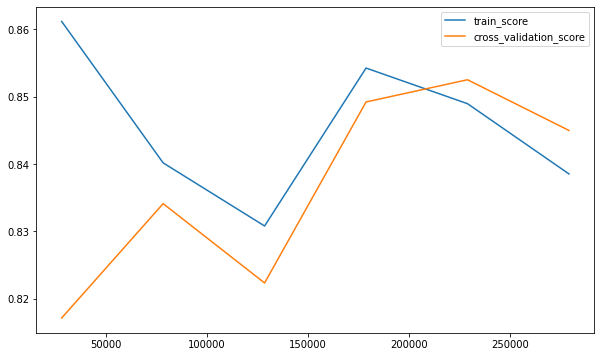

In [ ]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="entropy", class_weight = "balanced", max_depth = 30, max_features=5, min_samples_split=0.1 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [ ]:
quarantiles(model=final_model_DecisionTreeClassifier, data_orig=data_orig, affichage=True, save=True, path = "/content/drive/MyDrive/spad_score_method_1/avec_tranche_DecisionTreeClassifier.xlsx")

                 IDENT     PROBA
75758    7575902665301  0.000000
26772    2677301344932  0.000000
243649  24365003952578  0.000000
431303  43130404172552  0.000000
431296  43129704172545  0.000000
...                ...       ...
278015  27801603996262  0.892176
278014  27801503996261  0.892176
55779    5578002089984  0.892176
55710    5571102088840  0.892176
484521  48452204239268  0.892176

[484522 rows x 2 columns]
0.033456    44187
0.368623    42987
0.801501    42106
0.061700    39743
0.151976    37858
0.222079    35240
0.085135    35114
0.027059    31231
0.892176    28502
0.082680    21708
0.117073    21437
0.022146    19287
0.258667    13220
0.052689    11756
0.265246    11481
0.858309    10615
0.000000    10397
0.886319    10379
0.155960     9543
0.172668     3174
0.271908     2934
0.315999     1410
0.490825      213
Name: PROBA, dtype: int64


ValueError: ignored

(484522, 24)

In [ ]:
####################################################################################
####################################################################################
#                    SANS VARIABLES DONS
####################################################################################
####################################################################################

In [ ]:

# test predict individus sans classe
data = data_orig.copy()

# il nous faut toutes les variables (*,24)
print("dim data_orig: ",data.shape)

# on élimine les variables dons
data=data.drop(["Annee_1er_don", "Cumul_dons","Don_max", "Don_moyen"],axis=1)

# élimination des individus n'ayant pas de valeur pour la varialbe IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

# base de données avec des variables corrélées et sans encodage OneHot
data =data_sans_nan

nb_var = data.shape[1] - 1
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

dim data_orig:  (484522, 24)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


test set : 
[[  385   113]
 [43574 49019]]
              precision    recall  f1-score   support

           1       0.01      0.77      0.02       498
           2       1.00      0.53      0.69     92593

    accuracy                           0.53     93091
   macro avg       0.50      0.65      0.35     93091
weighted avg       0.99      0.53      0.69     93091

train set : 
[[  1609    513]
 [174487 195753]]
              precision    recall  f1-score   support

           1       0.01      0.76      0.02      2122
           2       1.00      0.53      0.69    370240

    accuracy                           0.53    372362
   macro avg       0.50      0.64      0.35    372362
weighted avg       0.99      0.53      0.69    372362



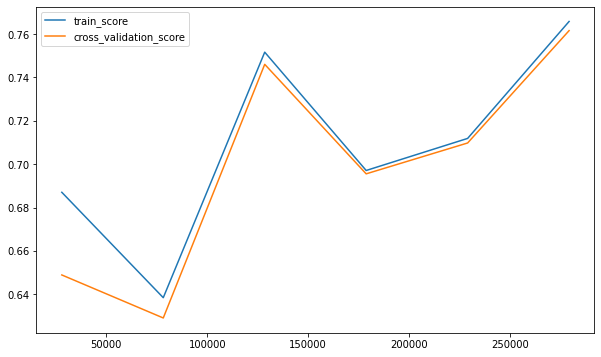

In [ ]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="gini", class_weight = "balanced", max_depth = 2, max_features=7, min_samples_split=0.1 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [ ]:
quarantiles(model=final_model_DecisionTreeClassifier, data_orig=data_orig, affichage=True, save=True, path = "/content/drive/MyDrive/spad_score_method_1/sans_tranche_DecisionTreeClassifier.xlsx")

                 IDENT     PROBA
484521  48452204239268  0.313773
220803  22080403910938  0.313773
220802  22080303910937  0.313773
220801  22080203910931  0.313773
385988  38598904126038  0.313773
...                ...       ...
403417  40341804143891  0.716598
177812  17781303634458  0.716598
403412  40341304143886  0.716598
177744  17774503633679  0.716598
411434  41143504152097  0.716598

[484522 rows x 2 columns]
0.313773    308986
0.538221    103246
0.716598     72290
Name: PROBA, dtype: int64


ValueError: ignored

In [ ]:
###################################################################################################################@
###################################################################################################################@
#                                                AVEC VARIABLES QUALITATIVES
###################################################################################################################@
###################################################################################################################@

In [44]:
# test predict individus sans classe
data = data_orig.copy()

# encodage Onehot sur toutes les données (on évite ainsi les erreurs futures)
nb_var = data.shape[1] - 1
encodage = OneHotEncoder()
encodage.fit(data_processing(data.iloc[:,1:nb_var]))

#data_quali = pd.DataFrame()
#data_quali["IDENT"]=

# élimination des individus n'ayant pas de valeur pour la varialbe IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

# base de données avec des variables corrélées et avec encodage OneHot
data =data_sans_nan

nb_var = data.shape[1] - 1
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

train_X_s = encodage.transform(data_processing(train_set.iloc[:,1:nb_var])).toarray()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = encodage.transform(data_processing(test_set.iloc[:,1:nb_var])).toarray()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [31]:

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, class_weight = "balanced" )
param = { 'max_depth' :list(range(2,30)), 'criterion': ["gini", "entropy"], 'max_features' : [10,16,20],
         'min_samples_split' : np.linspace(0.1, 1.0, 5) }

grid_DecisionTreeClassifier = GridSearchCV(model_DecisionTreeClassifier, param_grid= param, cv = 4, scoring = "recall")
resultat_grid_DecisionTreeClassifier = grid_DecisionTreeClassifier.fit(train_X_s, train_Y_s)
resultat_grid_DecisionTreeClassifier.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 10,
 'min_samples_split': 1.0}

test set : 
[[  400    98]
 [54774 37819]]
              precision    recall  f1-score   support

           1       0.01      0.80      0.01       498
           2       1.00      0.41      0.58     92593

    accuracy                           0.41     93091
   macro avg       0.50      0.61      0.30     93091
weighted avg       0.99      0.41      0.58     93091

train set : 
[[  1700    422]
 [219023 151217]]
              precision    recall  f1-score   support

           1       0.01      0.80      0.02      2122
           2       1.00      0.41      0.58    370240

    accuracy                           0.41    372362
   macro avg       0.50      0.60      0.30    372362
weighted avg       0.99      0.41      0.58    372362



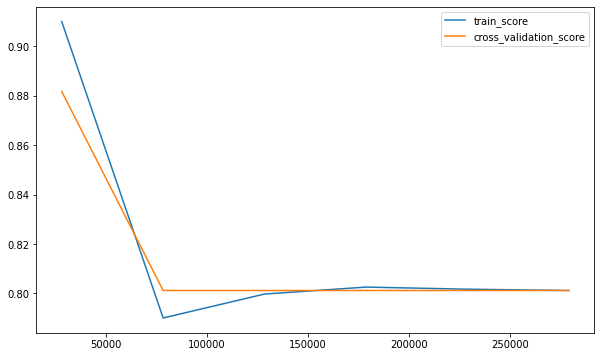

In [32]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="gini", class_weight = "balanced", max_depth = 2, max_features=10, min_samples_split=0.1 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [47]:
#importance des variables
#impVarFirst={"Variable":data.columns[1:-1],"Importance":final_model_DecisionTreeClassifier.feature_importances_}
impVarFirst={"Importance":final_model_DecisionTreeClassifier.feature_importances_}
pd.DataFrame(impVarFirst).sort_values(by="Importance",ascending=False)

,Importance
217,0.908653
165,0.089904
53,0.001443
173,0.000000
177,0.000000
...,...
92,0.000000
93,0.000000
94,0.000000
95,0.000000


In [35]:
quarantiles(model=final_model_DecisionTreeClassifier, data_orig=data_orig, affichage=True, save=False, path = "/content/drive/MyDrive/spad_score_method_1/avec_tranche_DecisionTreeClassifier.xlsx")

ValueError: ignored

In [45]:
encodage.transform(data_processing(data_orig.iloc[:,1:nb_var])).toarray().shape

(484522, 261)

In [ ]:
####################################################################################################################
# EN-DESSOUS A EFFACER

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_Y_s),
                                                 train_Y_s)
class_weights

array([87.73845429,  0.50286571])

In [ ]:
 462833/2620

176.65381679389313

In [ ]:
1/0.50286571

1.988602483951431

In [ ]:
87.73845429*1.988602483951431

174.4769081391531

In [ ]:
np.linspace(0.1, 1.0, 5)#, endpoint=True) 

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

In [ ]:
2122/372362 

In [ ]:
2620/484522

In [ ]:
import numpy as np

In [ ]:
np.linspace(0.1, 1, 6)

array([0.1 , 0.28, 0.46, 0.64, 0.82, 1.  ])

In [ ]:
np.linspace(0.1, 1, 10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
372362*0.82

305336.83999999997

In [ ]:
465453*0.64

310094.08

In [ ]:
279271/465453 

0.5999982812442932

In [ ]:
372362*3/4

279271.5

In [97]:
df = pd.DataFrame({'A': ['a', 'b', 'a'], 'B': ['b', 'a', 'c'],
                   'C': ['3', '1', '4']})

In [98]:
df

,A,B,C
0,a,b,3
1,b,a,1
2,a,c,4


In [99]:
pd.get_dummies(df)

,A_a,A_b,B_a,B_b,B_c,C_1,C_3,C_4
0,1,0,0,1,0,0,1,0
1,0,1,1,0,0,1,0,0
2,1,0,0,0,1,0,0,1


In [76]:
pd.get_dummies(data.iloc[:,1:(data.shape[1]-1)], columns=data.columns[1:(data.shape[1]-1)] )

,TypeHabi_1,TypeHabi_2,TypeHabi_3,TypeHabi_4,GeoFaz_Scl_11,GeoFaz_Scl_12,GeoFaz_Scl_13,GeoFaz_Scl_14,GeoFaz_Scl_15,GeoFaz_Scl_21,GeoFaz_Scl_22,GeoFaz_Scl_23,GeoFaz_Scl_24,GeoFaz_Scl_25,GeoFaz_Scl_31,GeoFaz_Scl_32,GeoFaz_Scl_33,GeoFaz_Scl_34,GeoFaz_Scl_35,GeoFaz_Scl_36,GeoFaz_Scl_37,GeoFaz_Scl_41,GeoFaz_Scl_42,GeoFaz_Scl_43,GeoFaz_Scl_44,GeoFaz_Scl_45,GeoFaz_Scl_46,GeoFaz_Scl_51,GeoFaz_Scl_52,GeoFaz_Scl_53,GeoFaz_Scl_54,GeoFaz_Scl_61,GeoFaz_Scl_62,GeoFaz_Scl_63,GeoFaz_Scl_64,GeoFaz_Scl_71,GeoFaz_Scl_72,GeoFaz_Scl_73,GeoFaz_Scl_74,GeoFaz_Scl_75,...,Cumul_dons_6,Cumul_dons_7,Cumul_dons_8,Don_max_1,Don_max_2,Don_max_3,Don_max_4,Don_max_5,Don_max_6,Don_max_7,Don_max_8,Don_max_9,Don_moyen_1,Don_moyen_2,Don_moyen_3,Don_moyen_4,Don_moyen_5,Don_moyen_6,Don_moyen_7,Vingtiles_ISF_1,Vingtiles_ISF_2,Vingtiles_ISF_3,Vingtiles_ISF_4,Vingtiles_ISF_5,Vingtiles_ISF_6,Vingtiles_ISF_7,Vingtiles_ISF_8,Vingtiles_ISF_9,Vingtiles_ISF_10,Vingtiles_ISF_11,Vingtiles_ISF_12,Vingtiles_ISF_13,Vingtiles_ISF_14,Vingtiles_ISF_15,Vingtiles_ISF_16,Vingtiles_ISF_17,Vingtiles_ISF_18,Vingtiles_ISF_19,Vingtiles_ISF_20,Vingtiles_ISF_21
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466512,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
466513,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
466514,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
466515,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [80]:
hhhh=pd.DataFrame()

In [82]:
hhhh["de"]=data.iloc[:,0]

In [84]:
hhhh =  pd.get_dummies(data.iloc[:,1:(data.shape[1]-1)], columns=data.columns[1:(data.shape[1]-1)] )

In [89]:
pd.concat([data.iloc[:,0],hhhh], axis=1 )

,IDENT,TypeHabi_1,TypeHabi_2,TypeHabi_3,TypeHabi_4,GeoFaz_Scl_11,GeoFaz_Scl_12,GeoFaz_Scl_13,GeoFaz_Scl_14,GeoFaz_Scl_15,GeoFaz_Scl_21,GeoFaz_Scl_22,GeoFaz_Scl_23,GeoFaz_Scl_24,GeoFaz_Scl_25,GeoFaz_Scl_31,GeoFaz_Scl_32,GeoFaz_Scl_33,GeoFaz_Scl_34,GeoFaz_Scl_35,GeoFaz_Scl_36,GeoFaz_Scl_37,GeoFaz_Scl_41,GeoFaz_Scl_42,GeoFaz_Scl_43,GeoFaz_Scl_44,GeoFaz_Scl_45,GeoFaz_Scl_46,GeoFaz_Scl_51,GeoFaz_Scl_52,GeoFaz_Scl_53,GeoFaz_Scl_54,GeoFaz_Scl_61,GeoFaz_Scl_62,GeoFaz_Scl_63,GeoFaz_Scl_64,GeoFaz_Scl_71,GeoFaz_Scl_72,GeoFaz_Scl_73,GeoFaz_Scl_74,...,Cumul_dons_6,Cumul_dons_7,Cumul_dons_8,Don_max_1,Don_max_2,Don_max_3,Don_max_4,Don_max_5,Don_max_6,Don_max_7,Don_max_8,Don_max_9,Don_moyen_1,Don_moyen_2,Don_moyen_3,Don_moyen_4,Don_moyen_5,Don_moyen_6,Don_moyen_7,Vingtiles_ISF_1,Vingtiles_ISF_2,Vingtiles_ISF_3,Vingtiles_ISF_4,Vingtiles_ISF_5,Vingtiles_ISF_6,Vingtiles_ISF_7,Vingtiles_ISF_8,Vingtiles_ISF_9,Vingtiles_ISF_10,Vingtiles_ISF_11,Vingtiles_ISF_12,Vingtiles_ISF_13,Vingtiles_ISF_14,Vingtiles_ISF_15,Vingtiles_ISF_16,Vingtiles_ISF_17,Vingtiles_ISF_18,Vingtiles_ISF_19,Vingtiles_ISF_20,Vingtiles_ISF_21
0,101001347,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,201001512,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,301002801,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,401003186,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,501003624,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466512,46651304217222,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
466513,46651404217223,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
466514,46651504217224,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
466515,46651604217225,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [93]:
hhhh.iloc[:,210:220]

,Annee_1er_don_4,Annee_1er_don_5,Annee_1er_don_6,Annee_1er_don_7,Annee_1er_don_8,Cumul_dons_1,Cumul_dons_2,Cumul_dons_3,Cumul_dons_4,Cumul_dons_5
0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
466512,0,0,0,0,0,0,1,0,0,0
466513,0,0,0,0,0,0,0,1,0,0
466514,0,0,0,0,0,0,0,1,0,0
466515,0,0,0,0,0,0,1,0,0,0
